In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = int(np.floor(extend_length / self.path_resolution))

        for _ in range(n_expand):
            new_node.x += self.path_resolution * np.cos(theta)
            new_node.y += self.path_resolution * np.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return np.hypot(dx, dy)

    def get_random_node(self):
        if np.random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                np.random.uniform(self.min_rand, self.max_rand),
                np.random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)
        return d, theta

In [5]:
show_animation = False

# ====Search Path with RRT====
obstacle_list = [
    (5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (6, 12, 1)
]  # [x,y,size(radius)]

# Set Initial parameters
rrt_star = RRTStar(
    start=[0, 0],
    goal=[6, 10],
    rand_area=[-2, 15],
    obstacle_list=obstacle_list,
    expand_dis=1,
    robot_radius=0.8)
path = rrt_star.planning(animation=show_animation)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt_star.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'r--')
        plt.grid(True)
        plt.show()


Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 2
Iter: 2 , number of nodes: 3
Iter: 3 , number of nodes: 4
Iter: 4 , number of nodes: 5
Iter: 5 , number of nodes: 6
Iter: 6 , number of nodes: 6
Iter: 7 , number of nodes: 7
Iter: 8 , number of nodes: 7
Iter: 9 , number of nodes: 7
Iter: 10 , number of nodes: 8
Iter: 11 , number of nodes: 9
Iter: 12 , number of nodes: 9
Iter: 13 , number of nodes: 9
Iter: 14 , number of nodes: 10
Iter: 15 , number of nodes: 11
Iter: 16 , number of nodes: 12
Iter: 17 , number of nodes: 12
Iter: 18 , number of nodes: 12
Iter: 19 , number of nodes: 12
Iter: 20 , number of nodes: 13
Iter: 21 , number of nodes: 14
Iter: 22 , number of nodes: 15
Iter: 23 , number of nodes: 16
Iter: 24 , number of nodes: 16
Iter: 25 , number of nodes: 17
Iter: 26 , number of nodes: 17
Iter: 27 , number of nodes: 18
Iter: 28 , number of nodes: 18
Iter: 29 , number of nodes: 19
Iter: 30 , number of nodes: 19
Iter: 31 , number of nodes: 19
Iter: 32 , number of nodes: 19
I

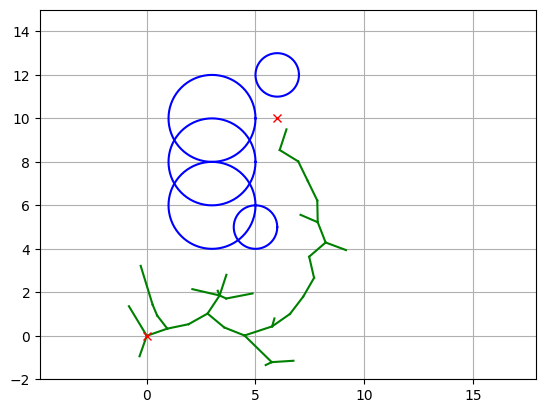

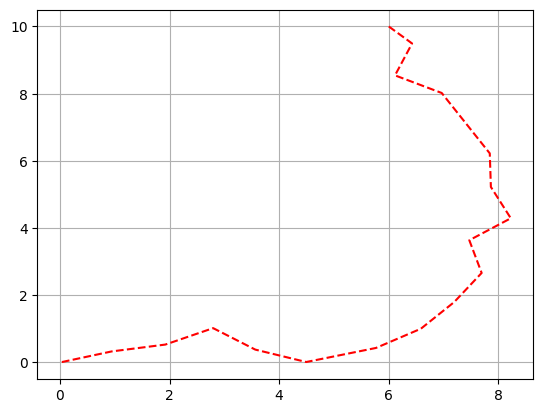

In [6]:
plt.xlim(-15,15)
plt.xlim(-10,10)
rrt_star.draw_graph()
plt.plot([x for (x, y) in path], [y for (x, y) in path], 'r--')
plt.grid(True)
plt.show()

In [7]:
from scipy.spatial.transform import Rotation as Rot

In [8]:
def rot_mat_2d(angle):
    """
    Create 2D rotation matrix from an angle

    Parameters
    ----------
    angle :

    Returns
    -------
    A 2D rotation matrix

    Examples
    --------
    >>> angle_mod(-4.0)


    """
    return Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]


def angle_mod(x, zero_2_2pi=False, degree=False):
    """
    Angle modulo operation
    Default angle modulo range is [-pi, pi)

    Parameters
    ----------
    x : float or array_like
        A angle or an array of angles. This array is flattened for
        the calculation. When an angle is provided, a float angle is returned.
    zero_2_2pi : bool, optional
        Change angle modulo range to [0, 2pi)
        Default is False.
    degree : bool, optional
        If True, then the given angles are assumed to be in degrees.
        Default is False.

    Returns
    -------
    ret : float or ndarray
        an angle or an array of modulated angle.

    Examples
    --------
    >>> angle_mod(-4.0)
    2.28318531

    >>> angle_mod([-4.0])
    np.array(2.28318531)

    >>> angle_mod([-150.0, 190.0, 350], degree=True)
    array([-150., -170.,  -10.])

    >>> angle_mod(-60.0, zero_2_2pi=True, degree=True)
    array([300.])

    """
    if isinstance(x, float):
        is_float = True
    else:
        is_float = False

    x = np.asarray(x).flatten()
    if degree:
        x = np.deg2rad(x)

    if zero_2_2pi:
        mod_angle = x % (2 * np.pi)
    else:
        mod_angle = (x + np.pi) % (2 * np.pi) - np.pi

    if degree:
        mod_angle = np.rad2deg(mod_angle)

    if is_float:
        return mod_angle.item()
    else:
        return mod_angle

In [9]:
def plan_dubins_path(s_x, s_y, s_yaw, g_x, g_y, g_yaw, curvature,
                     step_size=0.1, selected_types=None):
    """
    Plan dubins path

    Parameters
    ----------
    s_x : float
        x position of the start point [m]
    s_y : float
        y position of the start point [m]
    s_yaw : float
        yaw angle of the start point [rad]
    g_x : float
        x position of the goal point [m]
    g_y : float
        y position of the end point [m]
    g_yaw : float
        yaw angle of the end point [rad]
    curvature : float
        curvature for curve [1/m]
    step_size : float (optional)
        step size between two path points [m]. Default is 0.1
    selected_types : a list of string or None
        selected path planning types. If None, all types are used for
        path planning, and minimum path length result is returned.
        You can select used path plannings types by a string list.
        e.g.: ["RSL", "RSR"]

    Returns
    -------
    x_list: array
        x positions of the path
    y_list: array
        y positions of the path
    yaw_list: array
        yaw angles of the path
    modes: array
        mode list of the path
    lengths: array
        arrow_length list of the path segments.

    Examples
    --------
    You can generate a dubins path.

    >>> start_x = 1.0  # [m]
    >>> start_y = 1.0  # [m]
    >>> start_yaw = np.deg2rad(45.0)  # [rad]
    >>> end_x = -3.0  # [m]
    >>> end_y = -3.0  # [m]
    >>> end_yaw = np.deg2rad(-45.0)  # [rad]
    >>> curvature = 1.0
    >>> path_x, path_y, path_yaw, mode, _ = plan_dubins_path(
                start_x, start_y, start_yaw, end_x, end_y, end_yaw, curvature)
    >>> plt.plot(path_x, path_y, label="final course " + "".join(mode))
    >>> plot_arrow(start_x, start_y, start_yaw)
    >>> plot_arrow(end_x, end_y, end_yaw)
    >>> plt.legend()
    >>> plt.grid(True)
    >>> plt.axis("equal")
    >>> plt.show()

    .. image:: dubins_path.jpg
    """
    if selected_types is None:
        planning_funcs = _PATH_TYPE_MAP.values()
    else:
        planning_funcs = [_PATH_TYPE_MAP[ptype] for ptype in selected_types]

    # calculate local goal x, y, yaw
    l_rot = rot_mat_2d(s_yaw)
    le_xy = np.stack([g_x - s_x, g_y - s_y]).T @ l_rot
    local_goal_x = le_xy[0]
    local_goal_y = le_xy[1]
    local_goal_yaw = g_yaw - s_yaw

    lp_x, lp_y, lp_yaw, modes, lengths = _dubins_path_planning_from_origin(
        local_goal_x, local_goal_y, local_goal_yaw, curvature, step_size,
        planning_funcs)

    # Convert a local coordinate path to the global coordinate
    rot = rot_mat_2d(-s_yaw)
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + s_x
    y_list = converted_xy[:, 1] + s_y
    yaw_list = angle_mod(np.array(lp_yaw) + s_yaw)

    return x_list, y_list, yaw_list, modes, lengths


def _mod2pi(theta):
    return angle_mod(theta, zero_2_2pi=True)


def _calc_trig_funcs(alpha, beta):
    sin_a = np.sin(alpha)
    sin_b = np.sin(beta)
    cos_a = np.cos(alpha)
    cos_b = np.cos(beta)
    cos_ab = np.cos(alpha - beta)
    return sin_a, sin_b, cos_a, cos_b, cos_ab


def _LSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "S", "L"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_a - sin_b))
    if p_squared < 0:  # invalid configuration
        return None, None, None, mode
    tmp = np.arctan2((cos_b - cos_a), d + sin_a - sin_b)
    d1 = _mod2pi(-alpha + tmp)
    d2 = np.sqrt(p_squared)
    d3 = _mod2pi(beta - tmp)
    return d1, d2, d3, mode


def _RSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "S", "R"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_b - sin_a))
    if p_squared < 0:
        return None, None, None, mode
    tmp = np.arctan2((cos_a - cos_b), d - sin_a + sin_b)
    d1 = _mod2pi(alpha - tmp)
    d2 = np.sqrt(p_squared)
    d3 = _mod2pi(-beta + tmp)
    return d1, d2, d3, mode


def _LSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = -2 + d ** 2 + (2 * cos_ab) + (2 * d * (sin_a + sin_b))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = np.sqrt(p_squared)
    tmp = np.arctan2((-cos_a - cos_b), (d + sin_a + sin_b)) - np.arctan2(-2.0, d1)
    d2 = _mod2pi(-alpha + tmp)
    d3 = _mod2pi(-_mod2pi(beta) + tmp)
    return d2, d1, d3, mode


def _RSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = d ** 2 - 2 + (2 * cos_ab) - (2 * d * (sin_a + sin_b))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = np.sqrt(p_squared)
    tmp = np.arctan2((cos_a + cos_b), (d - sin_a - sin_b)) - np.arctan2(2.0, d1)
    d2 = _mod2pi(alpha - tmp)
    d3 = _mod2pi(beta - tmp)
    return d2, d1, d3, mode


def _RLR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "L", "R"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (sin_a - sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * np.pi - np.arccos(tmp))
    d1 = _mod2pi(alpha - np.arctan2(cos_a - cos_b, d - sin_a + sin_b) + d2 / 2.0)
    d3 = _mod2pi(alpha - beta - d1 + d2)
    return d1, d2, d3, mode


def _LRL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "R", "L"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (- sin_a + sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * np.pi - np.arccos(tmp))
    d1 = _mod2pi(-alpha - np.arctan2(cos_a - cos_b, d + sin_a - sin_b) + d2 / 2.0)
    d3 = _mod2pi(_mod2pi(beta) - alpha - d1 + _mod2pi(d2))
    return d1, d2, d3, mode


_PATH_TYPE_MAP = {"LSL": _LSL, "RSR": _RSR, "LSR": _LSR, "RSL": _RSL,
                  "RLR": _RLR, "LRL": _LRL, }


def _dubins_path_planning_from_origin(end_x, end_y, end_yaw, curvature,
                                      step_size, planning_funcs):
    dx = end_x
    dy = end_y
    d = np.hypot(dx, dy) * curvature

    theta = _mod2pi(np.arctan2(dy, dx))
    alpha = _mod2pi(-theta)
    beta = _mod2pi(end_yaw - theta)

    best_cost = float("inf")
    b_d1, b_d2, b_d3, b_mode = None, None, None, None

    for planner in planning_funcs:
        d1, d2, d3, mode = planner(alpha, beta, d)
        if d1 is None:
            continue

        cost = (abs(d1) + abs(d2) + abs(d3))
        if best_cost > cost:  # Select minimum length one.
            b_d1, b_d2, b_d3, b_mode, best_cost = d1, d2, d3, mode, cost

    lengths = [b_d1, b_d2, b_d3]
    x_list, y_list, yaw_list = _generate_local_course(lengths, b_mode,
                                                      curvature, step_size)

    lengths = [length / curvature for length in lengths]

    return x_list, y_list, yaw_list, b_mode, lengths


def _interpolate(length, mode, max_curvature, origin_x, origin_y,
                 origin_yaw, path_x, path_y, path_yaw):
    if mode == "S":
        path_x.append(origin_x + length / max_curvature * np.cos(origin_yaw))
        path_y.append(origin_y + length / max_curvature * np.sin(origin_yaw))
        path_yaw.append(origin_yaw)
    else:  # curve
        ldx = np.sin(length) / max_curvature
        ldy = 0.0
        if mode == "L":  # left turn
            ldy = (1.0 - np.cos(length)) / max_curvature
        elif mode == "R":  # right turn
            ldy = (1.0 - np.cos(length)) / -max_curvature
        gdx = np.cos(-origin_yaw) * ldx + np.sin(-origin_yaw) * ldy
        gdy = -np.sin(-origin_yaw) * ldx + np.cos(-origin_yaw) * ldy
        path_x.append(origin_x + gdx)
        path_y.append(origin_y + gdy)

        if mode == "L":  # left turn
            path_yaw.append(origin_yaw + length)
        elif mode == "R":  # right turn
            path_yaw.append(origin_yaw - length)

    return path_x, path_y, path_yaw


def _generate_local_course(lengths, modes, max_curvature, step_size):
    p_x, p_y, p_yaw = [0.0], [0.0], [0.0]

    for (mode, length) in zip(modes, lengths):
        if length == 0.0:
            continue

        # set origin state
        origin_x, origin_y, origin_yaw = p_x[-1], p_y[-1], p_yaw[-1]

        current_length = step_size
        while abs(current_length + step_size) <= abs(length):
            p_x, p_y, p_yaw = _interpolate(current_length, mode, max_curvature,
                                           origin_x, origin_y, origin_yaw,
                                           p_x, p_y, p_yaw)
            current_length += step_size

        p_x, p_y, p_yaw = _interpolate(length, mode, max_curvature, origin_x,
                                       origin_y, origin_yaw, p_x, p_y, p_yaw)

    return p_x, p_y, p_yaw


In [15]:
class RRTStarDubins(RRTStar):
    """
    Class for RRT star planning with Dubins path
    """

    class Node(RRTStar.Node):
        """
        RRT Node
        """

        def __init__(self, x, y, yaw):
            super().__init__(x, y)
            self.yaw = yaw
            self.path_yaw = []

    def __init__(self, start, goal, obstacle_list, rand_area,
                 goal_sample_rate=10,
                 max_iter=200,
                 connect_circle_dist=50.0,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1], start[2])
        self.end = self.Node(goal[0], goal[1], goal[2])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.connect_circle_dist = connect_circle_dist

        self.curvature = 1.0  # for dubins path
        self.goal_yaw_th = np.deg2rad(1.0)
        self.goal_xy_th = 0.5
        self.robot_radius = robot_radius

    def planning(self, animation=True, search_until_max_iter=True):
        """
        RRT Star planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd)

            if self.check_collision(
                    new_node, self.obstacle_list, self.robot_radius):
                near_indexes = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_indexes)
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_indexes)

            if animation and i % 5 == 0:
                self.plot_start_goal_arrow()
                self.draw_graph(rnd)

            if (not search_until_max_iter) and new_node:  # check reaching the goal
                last_index = self.search_best_goal_node()
                if last_index:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index:
            return self.generate_final_course(last_index)
        else:
            print("Cannot find path")

        return None

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            plt.plot(ox, oy, "ok", ms=30 * size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        self.plot_start_goal_arrow()
        plt.pause(0.01)

    def plot_start_goal_arrow(self):
        pass
        # plot_arrow(self.start.x, self.start.y, self.start.yaw)
        # plot_arrow(self.end.x, self.end.y, self.end.yaw)

    def steer(self, from_node, to_node):

        px, py, pyaw, mode, course_lengths = \
            plan_dubins_path(
                from_node.x, from_node.y, from_node.yaw,
                to_node.x, to_node.y, to_node.yaw, self.curvature)

        if len(px) <= 1:  # cannot find a dubins path
            return None

        new_node = copy.deepcopy(from_node)
        new_node.x = px[-1]
        new_node.y = py[-1]
        new_node.yaw = pyaw[-1]

        new_node.path_x = px
        new_node.path_y = py
        new_node.path_yaw = pyaw
        new_node.cost += sum([abs(c) for c in course_lengths])
        new_node.parent = from_node

        return new_node

    def calc_new_cost(self, from_node, to_node):

        _, _, _, _, course_lengths = plan_dubins_path(
            from_node.x, from_node.y, from_node.yaw,
            to_node.x, to_node.y, to_node.yaw, self.curvature)

        cost = sum([abs(c) for c in course_lengths])

        return from_node.cost + cost

    def get_random_node(self):

        if np.random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(np.random.uniform(self.min_rand, self.max_rand),
                            np.random.uniform(self.min_rand, self.max_rand),
                            np.random.uniform(-np.pi, np.pi)
                            )
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y, self.end.yaw)

        return rnd

    def search_best_goal_node(self):

        goal_indexes = []
        for (i, node) in enumerate(self.node_list):
            if self.calc_dist_to_goal(node.x, node.y) <= self.goal_xy_th:
                goal_indexes.append(i)

        # angle check
        final_goal_indexes = []
        for i in goal_indexes:
            if abs(self.node_list[i].yaw - self.end.yaw) <= self.goal_yaw_th:
                final_goal_indexes.append(i)

        if not final_goal_indexes:
            return None

        min_cost = min([self.node_list[i].cost for i in final_goal_indexes])
        for i in final_goal_indexes:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def generate_final_course(self, goal_index):
        print("final")
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_index]
        while node.parent:
            for (ix, iy) in zip(reversed(node.path_x), reversed(node.path_y)):
                path.append([ix, iy])
            node = node.parent
        path.append([self.start.x, self.start.y])
        return path

In [16]:
obstacleList = [
    (5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
]  # [x,y,size(radius)]

# Set Initial parameters
start = [0.0, 0.0, np.deg2rad(0.0)]
goal = [10.0, 10.0, np.deg2rad(0.0)]

rrtstar_dubins = RRTStarDubins(start, goal, rand_area=[-2.0, 15.0], obstacle_list=obstacleList)
path = rrtstar_dubins.planning(animation=show_animation)

# Draw final path
if show_animation:  # pragma: no cover
    rrtstar_dubins.draw_graph()
    plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
    plt.grid(True)
    plt.pause(0.001)

    plt.show()

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 1
Iter: 2 , number of nodes: 2
Iter: 3 , number of nodes: 2
Iter: 4 , number of nodes: 2
Iter: 5 , number of nodes: 2
Iter: 6 , number of nodes: 2
Iter: 7 , number of nodes: 3
Iter: 8 , number of nodes: 3
Iter: 9 , number of nodes: 4
Iter: 10 , number of nodes: 4
Iter: 11 , number of nodes: 5
Iter: 12 , number of nodes: 6
Iter: 13 , number of nodes: 6
Iter: 14 , number of nodes: 6
Iter: 15 , number of nodes: 7
Iter: 16 , number of nodes: 8
Iter: 17 , number of nodes: 9
Iter: 18 , number of nodes: 9
Iter: 19 , number of nodes: 10
Iter: 20 , number of nodes: 11
Iter: 21 , number of nodes: 11
Iter: 22 , number of nodes: 11
Iter: 23 , number of nodes: 11
Iter: 24 , number of nodes: 11
Iter: 25 , number of nodes: 12
Iter: 26 , number of nodes: 12
Iter: 27 , number of nodes: 12
Iter: 28 , number of nodes: 13
Iter: 29 , number of nodes: 13
Iter: 30 , number of nodes: 14
Iter: 31 , number of nodes: 15
Iter: 32 , number of nodes: 15
Iter: 

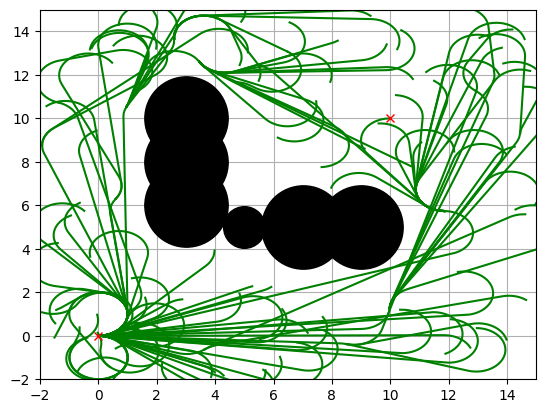

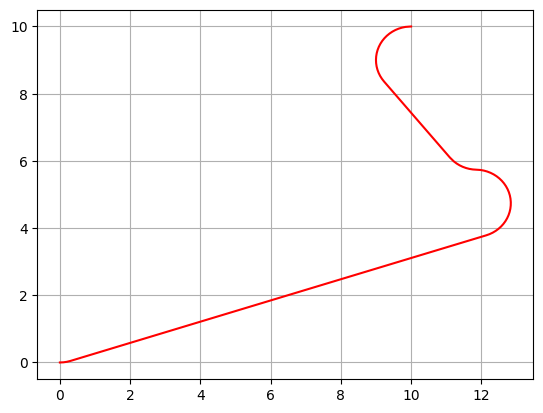

In [17]:
rrtstar_dubins.draw_graph()
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
plt.grid(True)
plt.pause(0.001)

plt.show()